# Setup

In [ ]:
import os
import shutil
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [18]:
pip install keras-tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [2]:
train_image_folder_path = '/kaggle/input/traffic-sign-recogntion-database/tsrd-train'
test_image_folder_path = '/kaggle/input/traffic-sign-recogntion-database/TSRD-Test'

train_txt_file = '/kaggle/input/traffic-sign-recogntion-database/TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt'
test_txt_file = '/kaggle/input/traffic-sign-recogntion-database/TSRD-Test Annotation/TsignRecgTest1994Annotation.txt'

train_folder_filenames = [f for f in os.listdir(train_image_folder_path) if f.endswith('.png')]
print(f"Total images in train folder: {len(train_folder_filenames)}")
test_folder_filenames = [f for f in os.listdir(test_image_folder_path) if f.endswith('.png')]
print(f"Total images in test folder: {len(test_folder_filenames)}")

Total images in train folder: 4170
Total images in test folder: 1994


# Data Ingestion

In [3]:
def read_txt_file(input_txt_file):
    """
    Reads and processes data from a .txt file.
    
    Args:
    input_txt_file (str): Path to the input .txt file.
    
    Returns:
    list: Processed data from the .txt file.
    """
    data = []
    with open(input_txt_file, 'r') as file:
        for line in file:
            line_data = line.strip().split(';')
            line_data = line_data[0:8]
            data.append(line_data)
    return data

def write_csv_file(data, output_csv_file):
    """
    Writes data into a .csv file.
    
    Args:
    data (list): List of processed data to write into the .csv file.
    output_csv_file (str): Path to the output .csv file.
    """
    with open(output_csv_file, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['file_name', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'category'])  # Header
        writer.writerows(data)
    print(f"Data successfully written to {output_csv_file}")

In [4]:
#Convert txt file format in csv format for easier retrieve
train_output_csv_file = '/kaggle/working/train-annotation.csv'
test_output_csv_file = '/kaggle/working/test-annotation.csv'

train_data = read_txt_file(train_txt_file)
test_data = read_txt_file(test_txt_file)

write_csv_file(train_data, train_output_csv_file)
write_csv_file(test_data, test_output_csv_file)

Data successfully written to /kaggle/working/train-annotation.csv
Data successfully written to /kaggle/working/test-annotation.csv


In [5]:
#Read csv file
train_df = pd.read_csv(train_output_csv_file)
test_df = pd.read_csv(test_output_csv_file)
print(train_df.head())

      file_name  width  height  x1  y1   x2   y2  category
0  000_0001.png    134     128  19   7  120  117         0
1  000_0002.png    165     151  23  12  149  138         0
2  000_0003.png    128     122  22  14  116  105         0
3  000_0010.png     80      73  14   8   67   63         0
4  000_0011.png    186     174  36  15  155  157         0


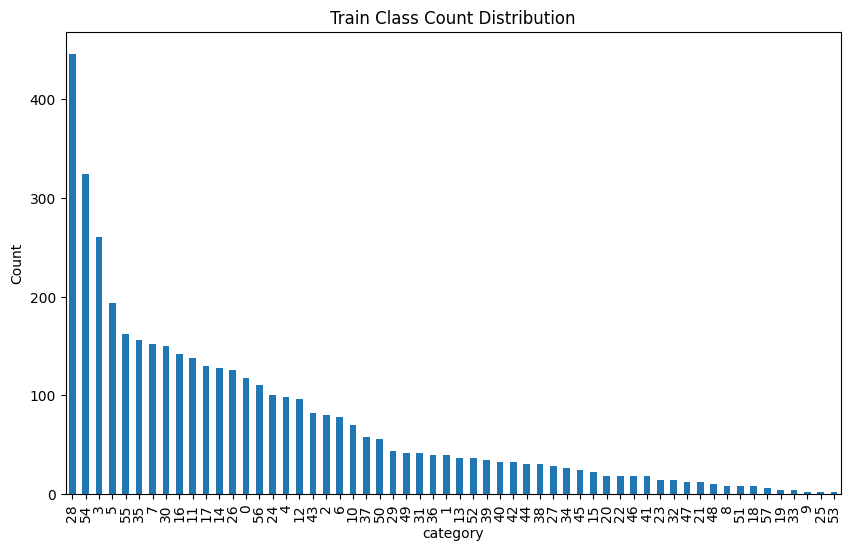

In [6]:
train_df['category'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title('Train Class Count Distribution')
plt.ylabel('Count')
plt.show()


# Image Crop

In [7]:
# Function to crop and save images
def crop_and_save_images(df, input_dir, output_dir):
    for index, row in df.iterrows():
        file_name = row['file_name']
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        
        # Load the image
        img_path = os.path.join(input_dir, file_name)
        image = cv2.imread(img_path)
        
        if image is not None:
            # Crop the image
            cropped_image = image[y1:y2, x1:x2]
            
            # Save the cropped image
            cropped_img_path = os.path.join(output_dir, file_name)
            cv2.imwrite(cropped_img_path, cropped_image)
        else:
            print(f"Image {file_name} not found in {input_dir}")

In [8]:
# Directory to save cropped images
train_crop_dir = '/kaggle/working/crop_trained_images'
test_crop_dir = '/kaggle/working/dataset/test'
os.makedirs(train_crop_dir, exist_ok=True)
os.makedirs(test_crop_dir, exist_ok=True)

# Crop and save images
crop_and_save_images(train_df, train_image_folder_path , train_crop_dir)
crop_and_save_images(test_df, test_image_folder_path, test_crop_dir)

print("Train and Test dataset Cropping completed.")

Train and Test dataset Cropping completed.


In [9]:
test_dir = '/kaggle/working/dataset/test'

def load_images_and_labels(image_dir, csv_path, new_size=(128, 128)):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['file_name'])
        image = cv2.imread(img_path , cv2.IMREAD_COLOR)

        image_resized = cv2.resize(image, new_size)  # resize
        images.append(image_resized)
        labels.append(row['category'])
    
    images = np.array(images)
    labels = np.array(labels)
    
    # Expand dimensions to match input shape for CNN (new_size[0], new_size[1], 1)
    images = np.expand_dims(images, axis=-1)
    
    return images, labels

train_images, train_labels = load_images_and_labels(train_crop_dir, train_output_csv_file, new_size=(128, 128))
test_images, test_labels = load_images_and_labels(test_crop_dir, test_output_csv_file, new_size=(128, 128))


# Data Preprocessing
*   Image Resize to 128x128
*   Noise Reduction using Bilateral Filter
*   Gray Conversion from RGB color
*   Apply CLAHE
*   Normalization

In [10]:
def resize_image(image, target_size=(128, 128)):
    """Resize the image to the target size."""
    return cv2.resize(image, target_size)

def apply_grayscale(image):
    """Convert the image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_bilateral_filter(image):
    """Apply bilateral filtering to reduce noise while preserving edges."""
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def apply_clahe(image):
    """Apply CLAHE to a grayscale image."""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def normalize_image(image):
    """Normalize the image to the range [0, 1]."""
    return image.astype(np.float32) / 255.0

# Preprocess the images from the directories
def process_image(image):
    """Apply all preprocessing steps to the image."""
    image = resize_image(image)              # Step 1: Resize the image
    image = apply_bilateral_filter(image)    # Step 2: Reduce noise with bilateral filter
    image = apply_grayscale(image)  # Step 3: Convert to grayscale
    image = apply_clahe(image)               # Step 4: Apply CLAHE for contrast enhancement
    image = normalize_image(image)           # Step 5: Normalize the image to [0, 1]
    return image

# Preprocess the images from the directories
def preprocess_images(images):
    """Preprocess a batch of images."""
    processed_images = []
    for image in images:
        image = np.squeeze(image)
        processed_image = process_image(image)
        processed_images.append(processed_image)
    return np.array(processed_images)

In [11]:
# Preprocess training and validation images
X_preprocessed = preprocess_images(train_images)
X_test_preprocessed = preprocess_images(test_images)

# Expand dimensions to match input shape for CNN
X_preprocessed = np.expand_dims(X_preprocessed, axis=-1)
X_test_preprocessed = np.expand_dims(X_test_preprocessed, axis=-1)

# Print before and after image processing 

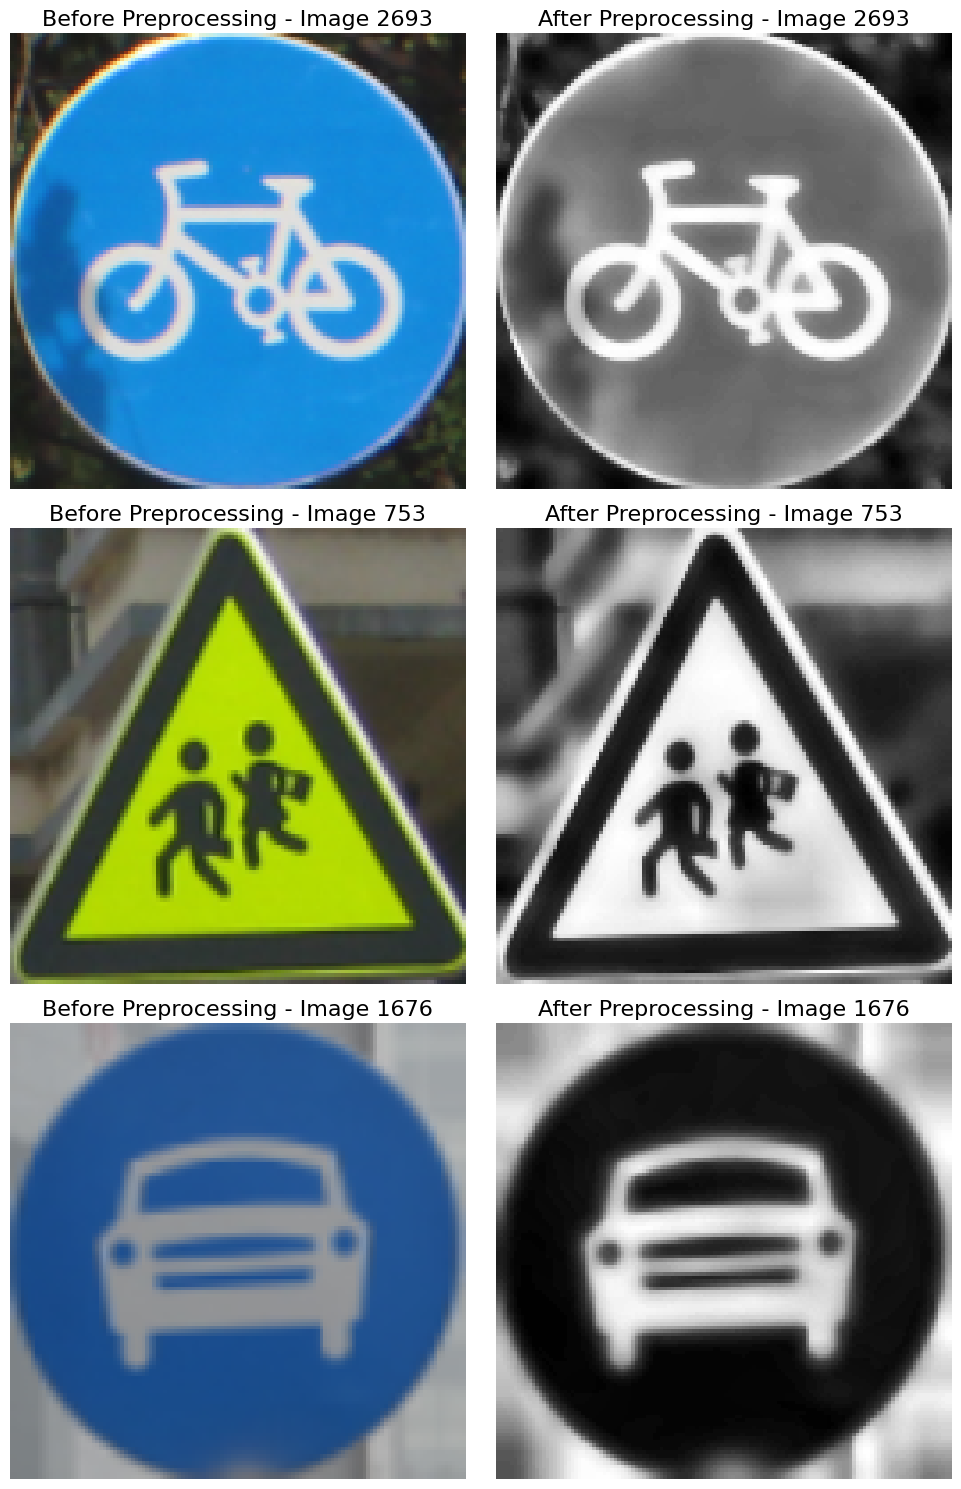

In [25]:
def display_before_after(images, preprocessed_images, title, num_images=3):
    """Visualize random images before and after preprocessing."""
    random_indices = np.random.choice(len(images), num_images, replace=False)
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i, idx in enumerate(random_indices):
        # Display the image before preprocessing
        original_image = images[idx]
        original_image = original_image.squeeze(-1)
        
        #Change from BGR TO RGB
        original_image = original_image[..., ::-1]
        
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f'Before {title} - Image {idx}', fontsize=16)
        axes[i, 0].axis('off')
        
        # Display the image after preprocessing
        preprocessed_image = preprocessed_images[idx]
        preprocessed_image = preprocessed_image.squeeze(-1)
        
        axes[i, 1].imshow(preprocessed_image, cmap='gray')
        axes[i, 1].set_title(f'After {title} - Image {idx}', fontsize=16)
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Print 3 random images before and after preprocessing for training and validation datasets
display_before_after(train_images, X_preprocessed, "Preprocessing", num_images=3)

# DATA SPLIT

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_preprocessed,
    train_labels,
    test_size=0.15,  # 15% for validation
    random_state=42, # Ensure reproducibility
    stratify=train_labels # To maintain the class distribution
)



# One-hot Encoding

In [14]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
y_train_encod = label_encoder.fit_transform(y_train)
y_val_encod = label_encoder.transform(y_val)  # Use transform to ensure consistent label encoding
y_test_encod = label_encoder.transform(test_labels)
num_classes = 58

# Apply one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encod, num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encod, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encod, num_classes)

# CNN Model Architecture

In [15]:
def cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),  # Added layer for larger images
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(1024, activation='relu'),  # Increased units for larger images
        Dense(num_classes, activation='softmax')
    ])
    return model



# Show the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 58)             │        59,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,885,498 (37.71 MB)

 Trainable params: 9,885,498 (37.71 MB)

 Non-trainable params: 0 (0.00 B)

# Training

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.4191 - loss: 2.5087 - val_accuracy: 0.9441 - val_loss: 0.2165
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9725 - loss: 0.1177 - val_accuracy: 0.9904 - val_loss: 0.0223
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9925 - loss: 0.0308 - val_accuracy: 0.9952 - val_loss: 0.0154
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9990 - loss: 0.0085 - val_accuracy: 0.9936 - val_loss: 0.0345
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9975 - loss: 0.0214 - val_accuracy: 0.9968 - val_loss: 0.0167
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9916 - loss: 0.0342 - val_accuracy: 0.9888 - val_loss: 0.0354
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9957 - loss: 0.0208 - val_accuracy: 0.9872 - val_loss: 0.0374
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9951 - loss: 0.0192 - val_ac

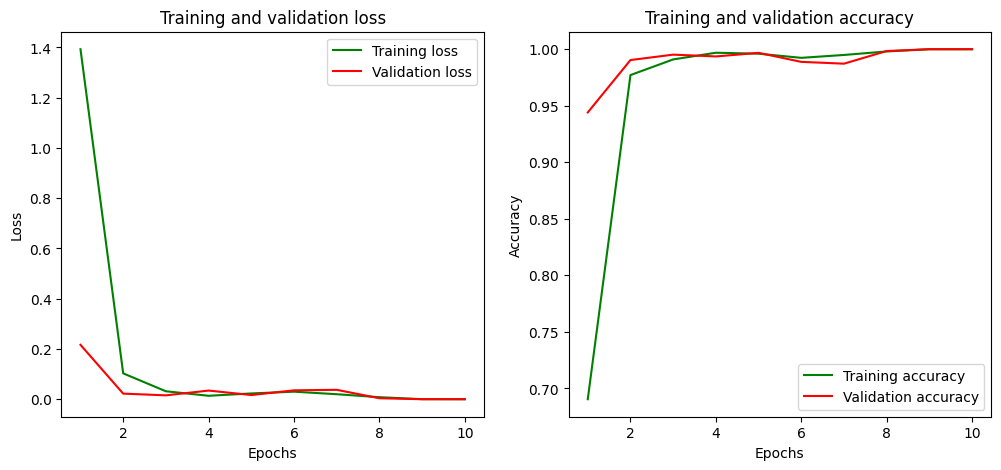

In [30]:
# Define input shape and number of classes
input_shape = (128, 128, 1) 
num_classes = 58

# Create the model
model = cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=10, validation_data=(X_val, y_val_one_hot), batch_size=32)

# Output the training results
print(f"Training complete. Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_one_hot, verbose=0)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)

# Plot the training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, color='green', label='Training loss')
plt.plot(epochs, val_loss, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, color='green', label='Training accuracy')
plt.plot(epochs, val_accuracy, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



# Model Evaluation

Test loss: 0.07178423553705215
Test accuracy: 0.9859578609466553
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.83      0.91        12
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        84
           4       0.96      0.93      0.95        58
           5       0.95      0.80      0.87        50
           6       1.00      1.00      1.00        30
           7       0.86      1.00      0.93        50
           8       1.00      1.00      1.00        14
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00        60
          11       1.00      1.00      1.00       130
          12       1.00      1.00      1.00        22
          13       0.98      1.00      0.99        92
          14       1.00      1.00      1.00        12
        

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

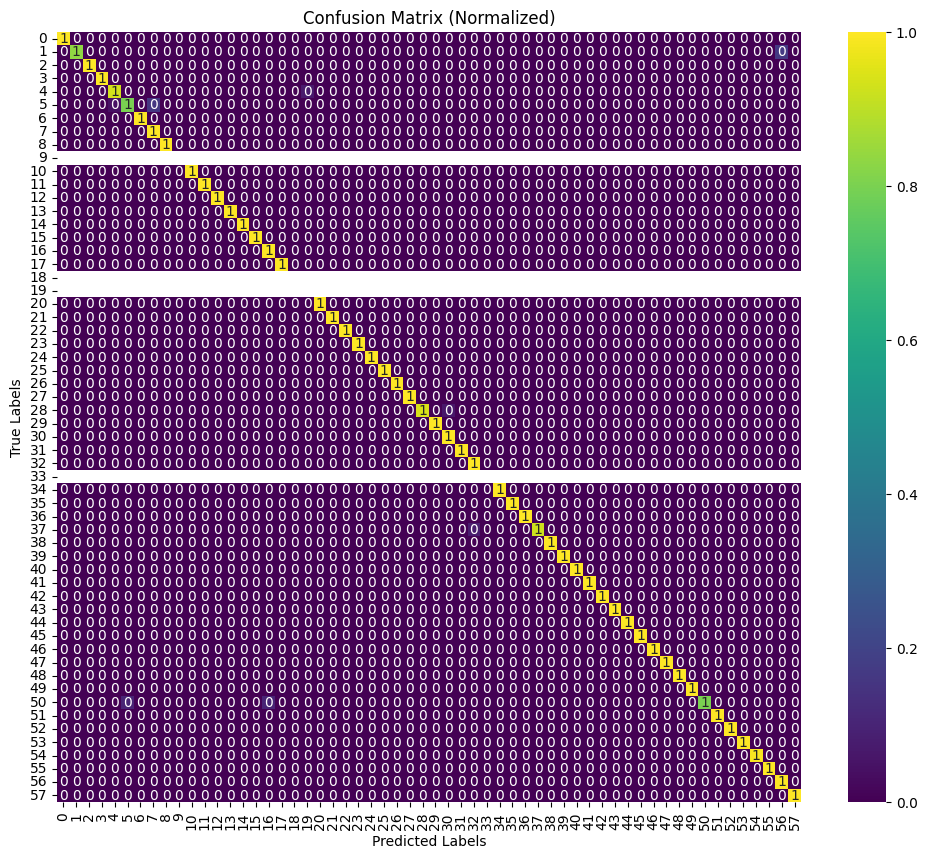

In [36]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_one_hot, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Create a list of class labels from 0 to 57
num_classes = 58
class_labels = list(range(num_classes))

# Evaluate precision, recall, F1-score, and accuracy
print("Classification Report:")
print(classification_report(y_test_encod, y_pred_classes, labels=class_labels, target_names=[str(i) for i in class_labels]))

# Compute overall accuracy
accuracy = accuracy_score(y_test_encod, y_pred_classes)
print(f"Overall accuracy: {accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encod, y_pred_classes, labels=class_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))

# Use a more distinct colormap
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.0f', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()


# Hyperparameter Tuning

In [19]:
import kerastuner as kt
from tensorflow.keras.optimizers import Adam

# Define the model building function for hyperparameter tuning
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set the number of trials to 5
    executions_per_trial=1,  # Number of executions per trial (typically 1)
    directory='my_dir',
    project_name='intro_to_kt'
)

# Perform hyperparameter tuning
tuner.search(
    X_train, y_train_one_hot,
    epochs=10,
    validation_data=(X_val, y_val_one_hot)
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
print(f"Best model validation accuracy: {best_model.evaluate(X_val, y_val_one_hot, verbose=0)[1]:.4f}")

Trial 5 Complete [00h 00m 23s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 14s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model validation accuracy: 1.0000


# Model Output (DEMO)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True class: Class 11
Predicted class: Class 11


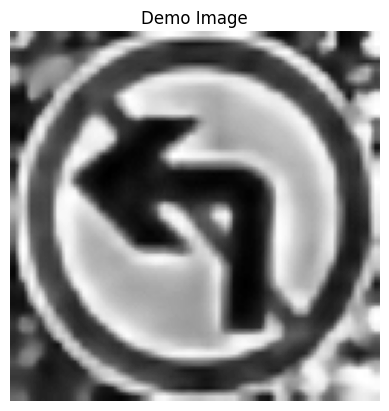

Top 3 Predicted Labels and Probabilities:
Class 11: 99.93%
Class 17: 0.06%
Class 27: 0.01%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True class: Class 56
Predicted class: Class 48


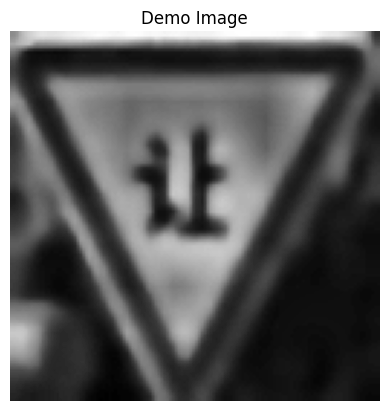

Top 3 Predicted Labels and Probabilities:
Class 48: 63.90%
Class 56: 16.47%
Class 3: 4.67%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True class: Class 26
Predicted class: Class 26


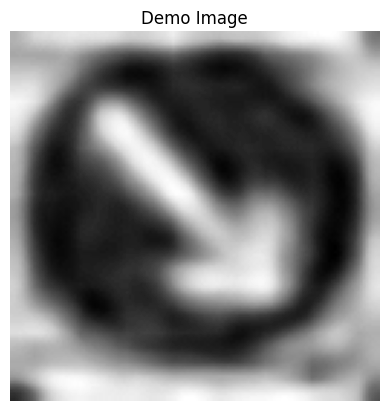

Top 3 Predicted Labels and Probabilities:
Class 26: 99.84%
Class 54: 0.06%
Class 28: 0.03%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True class: Class 2
Predicted class: Class 2


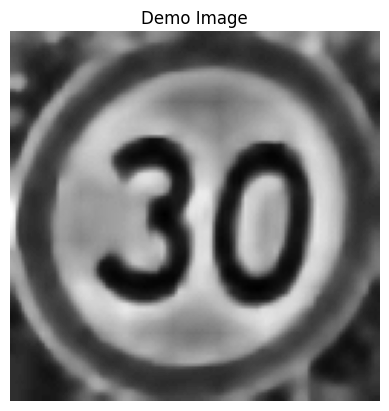

Top 3 Predicted Labels and Probabilities:
Class 2: 94.91%
Class 4: 4.85%
Class 7: 0.13%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True class: Class 6
Predicted class: Class 2


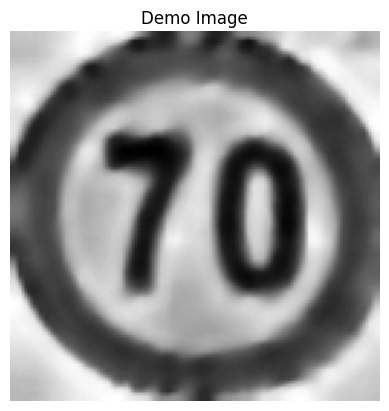

Top 3 Predicted Labels and Probabilities:
Class 2: 83.38%
Class 6: 15.68%
Class 3: 0.35%




In [40]:
import random

# Randomly select 5 images
selected_indices = random.sample(range(len(X_test_preprocessed)), 5)
selected_images = [X_test_preprocessed[i] for i in selected_indices]
selected_labels = [np.argmax(y_test_one_hot[i]) for i in selected_indices]  # Decode one-hot labels

# 58 total classes (0 to 57)
class_labels = [f"Class {i}" for i in range(58)]

# Process and predict each selected image
for image, true_label in zip(selected_images, selected_labels):
    # Add batch and channel dimensions
    demo_image = np.expand_dims(image, axis=0)  # Add batch dimension
    demo_image = np.expand_dims(demo_image, axis=-1)  # Add channel dimension if needed
    
    # Make predictions using the trained model
    prediction = best_model.predict(demo_image)
    predicted_class = np.argmax(prediction[0])  # Get the index of the highest probability

    # Print the predicted and true class labels
    print(f"True class: {class_labels[true_label]}")
    print(f"Predicted class: {class_labels[predicted_class]}")

    # Show the demo image
    # Convert the demo image from grayscale to RGB for displaying
    demo_image_rgb = np.squeeze(demo_image, axis=0)  # Remove batch dimension
    demo_image_rgb = np.squeeze(demo_image_rgb, axis=-1)  # Remove channel dimension
    plt.imshow(demo_image_rgb, cmap='gray')
    plt.title(f'Demo Image')
    plt.axis('off')
    plt.show()

    # Get the top 3 predicted classes with their probabilities
    top_3_indices = np.argsort(prediction[0])[-3:][::-1]
    print("Top 3 Predicted Labels and Probabilities:")
    for i in top_3_indices:
        print(f"{class_labels[i]}: {prediction[0][i] * 100:.2f}%")
    print("\n")

# Data Class Imbalance 